In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
Y_train = np.loadtxt('train.txt', dtype='int')
Y_test = np.loadtxt('test.txt', dtype='int')

## Helper Functions

In [3]:
def grad_U(Yij, Ui, ai, Vj, bj, mu, r, eta):
    """
    Gradient of the regularized loss function with respect to Ui multiplied by eta.
    """
    # Calculate gradient
    grad = r * Ui - 2 * Vj * (Yij - mu - np.dot(Ui, Vj) - ai - bj)
    # Scale by learning rate
    scaledGrad = eta * grad
    return scaledGrad

def grad_V(Yij, Ui, ai, Vj, bj, mu, r, eta):
    """
    Gradient of the regularized loss function with respect to Vj multiplied by eta.
    """
    # Calculate gradient
    grad = r * Vj - 2 * Ui * (Yij - mu - np.dot(Ui, Vj) - ai - bj)
    # Scale by learning rate
    scaledGrad = eta * grad
    return scaledGrad

def grad_A(Yij, Ui, ai, Vj, bj, mu, r, eta):
    """
    Gradient of the regularized loss function with respect to Ai multiplied by eta.
    """
    # Calculate gradient
    grad = r * ai - 2 * (Yij - mu - np.dot(Ui, Vj) - ai - bj)
    # Scale by learning rate
    scaledGrad = eta * grad
    return scaledGrad

def grad_B(Yij, Ui, ai, Vj, bj, mu, r, eta):
    """
    Gradient of the regularized loss function with respect to Bj multiplied by eta.
    """
    # Calculate gradient
    grad = r * bj - 2 * (Yij - mu - np.dot(Ui, Vj) - ai - bj)
    # Scale by learning rate
    scaledGrad = eta * grad
    return scaledGrad

def get_err(Y, U, A, V, B, mu, reg=0.0):
    """
    Returns the mean regularized squared-error.
    """
    # Calculate regularization penalty
    regularization_err = .5 * reg * ( np.linalg.norm(U, ord='fro')**2 
                                      + np.linalg.norm(V, ord='fro')**2 
                                      + np.linalg.norm(A, ord=2)**2
                                      + np.linalg.norm(B, ord=2)**2)
    # Find total squared error
    squared_err = 0
    for triple in Y:
        # For each user/movie pair in the dataset, calculate the error in the
        # model's prediction
        [i, j, rating] = triple
        err = (rating - mu - np.dot(U[i-1,:], V[j-1,:]) - A[i-1] - B[j-1])**2
        squared_err += err
    # Total all error and divide by number of data points
    total_err = regularization_err + squared_err
    rmse = total_err / len(Y)
    return rmse

def train_model(M, N, K, eta, r, Y, eps=0.0001, max_epochs=300):
    """
    Returns (U, A, V, B, mu, err) where err is the unregularized MSE of the model.
    """
    # Initialize variables to track epoch count, training error reduction,
    # if iteration should continue, and number of data points
    err_reduction = []
    epoch_count = 0
    iterate = True
    n_datapoints = len(Y)
    # Initialize U, V, A, and B with small random values
    U = np.random.uniform(-.5,.5,(M,K))
    V = np.random.uniform(-.5,.5,(N,K))
    A = np.random.uniform(-.5,.5,(M,))
    B = np.random.uniform(-.5,.5,(N,))
    # Calculate bias mu
    mu = np.average(Y[:,2])
    # Calculate the error of this model pre-training
    err_old = get_err(Y, U, A, V, B, mu, r)
    err_new = err_old
    # Perform iterations of SGD
    while iterate:
        # Shuffle data points
        np.random.shuffle(Y)
        # Iterate through data points
        for triple in Y:
            # Unpack data point
            [i, j, Yij] = triple
            Ui = U[i-1,:]
            Ai = A[i-1]
            Vj = V[j-1,:]
            Bj = B[j-1]
            # Calculate gradient and updates
            U[i-1,:] = Ui - grad_U(Yij, Ui, Ai, Vj, Bj, mu, r, eta)
            A[i-1] = Ai - grad_A(Yij, Ui, Ai, Vj, Bj, mu, r, eta)
            V[j-1,:] = Vj - grad_V(Yij, Ui, Ai, Vj, Bj, mu, r, eta)
            B[j-1] = Bj - grad_B(Yij, Ui, Ai, Vj, Bj, mu, r, eta)
        # Calculate error and error reduction
        err_new = get_err(Y, U, A, V, B, mu, r)
        err_drop = err_old - err_new
        err_reduction.append(err_drop)
        err_old = err_new
        reduction_ratio = abs(err_reduction[-1]/err_reduction[0])
        # Increment epoch count
        epoch_count += 1
        # Check if iteration should terminate
        if (epoch_count >= max_epochs) or (reduction_ratio <= eps):
            iterate = False
    # Model is now fully trained. Calculate unregularized MSE
    mse = get_err(Y, U, A, V, B, mu)
    return (U, A, V, B, mu, mse)

## Find Optimal Regularization

Factorizing with  943  users,  1682  movies,  20  factors
Best regularization = 0.3


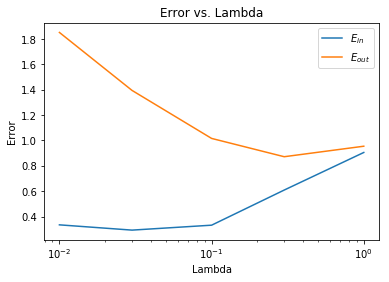

In [4]:
Y_sub_train = Y_train[:80000,:]
Y_sub_val = Y_train[80000:,:]

M = max(max(Y_sub_train[:,0]), max(Y_sub_val[:,0])).astype(int) # users
N = max(max(Y_sub_train[:,1]), max(Y_sub_val[:,1])).astype(int) # movies
K = 20 # factors
print("Factorizing with ", M, " users, ", N, " movies, ", K, " factors")

regs = [.01, .03, .1, .3, 1]
eta = 0.03 # learning rate

E_in = []
E_out = []
# Use to compute Ein and Eout
for r in regs:
    U,A,V,B,mu,err = train_model(M, N, K, eta, r, Y_sub_train)
    E_in.append(err)
    E_out.append(get_err(Y_sub_val, U, A, V, B, mu))

plt.semilogx(regs, E_in, label='$E_{in}$')
plt.semilogx(regs, E_out, label='$E_{out}$')
plt.title('Error vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.legend()

bestInd = np.argmin(E_out)
bestReg = regs[bestInd]

print("Best regularization = %s" % bestReg)

## Train Final Model

In [5]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
K = 20 # factors
print("Factorizing with ", M, " users, ", N, " movies, ", K, " factors")

eta = 0.03 # learning rate

# Train model and find accuracy
U,A,V,B,mu,E_in = train_model(M, N, K, eta, bestReg, Y_train)
E_out = get_err(Y_test, U, A, V, B, mu)

print("E_in = %s" % E_in)
print("E_out = %s" % E_out)

Factorizing with  943  users,  1682  movies,  20  factors
E_in = 0.6569065595332862
E_out = 0.8576184057201505
